### Loading of Images

In [1]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

/var/folders/_2/9tdd0_v908qf2_1bw_19j5wr0000gn/T/ipykernel_28741/1025810437.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


### Hyperparameters

In [2]:
epochs = 20
img_dimensions = (64, 64)
batch_size = 16
learning_rate = 1e-3

### Preprocessing

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=img_dimensions,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=img_dimensions,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
)

Found 985 files belonging to 3 classes.
Using 788 files for training.
Found 985 files belonging to 3 classes.
Using 197 files for validation.


2024-04-10 16:17:27.610812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


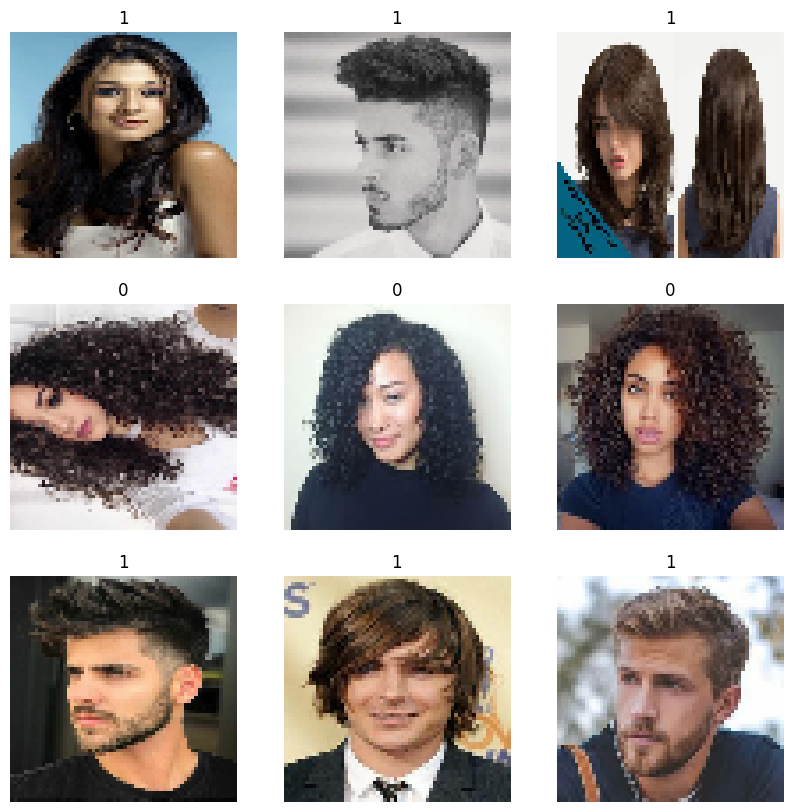

In [4]:
# looking at some sample images
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

### Modelling

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
import pydot as pydot

model = Sequential()
model.add(keras.Input(shape=img_dimensions + (3,))) # 64, 64, 3
model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(filters=4, kernel_size=16, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))

model.add(layers.Conv2D(filters=8, kernel_size=8, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))

model.add(layers.Conv2D(filters=16, kernel_size=4, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(64))
model.add(layers.Activation("relu"))
model.add(layers.Dense(3))
model.add(layers.Activation("softmax"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 49, 49, 4)      │         3,076 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 49, 49, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 8)      │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 42, 42, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 39, 39, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 39, 39, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,479 (33.12 KB)

 Trainable params: 8,479 (33.12 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [6]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.3317 - loss: 1.0998 - val_accuracy: 0.2843 - val_loss: 1.0995
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.3694 - loss: 1.0975 - val_accuracy: 0.2843 - val_loss: 1.0999
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.3685 - loss: 1.0801 - val_accuracy: 0.2995 - val_loss: 1.1470
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4007 - loss: 1.0575 - val_accuracy: 0.3959 - val_loss: 1.0652
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.4193 - loss: 1.0229 - val_accuracy: 0.4061 - val_loss: 1.0776
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.4872 - loss: 0.9820 - val_accuracy: 0.4619 - val_loss: 1.0446
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.4973 - loss: 0.9835 - val_accuracy: 0.4213 - val_loss: 1.0617
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.4529 - loss: 1.0024 - val_accuracy: 0.4264 - v

### Visualization 

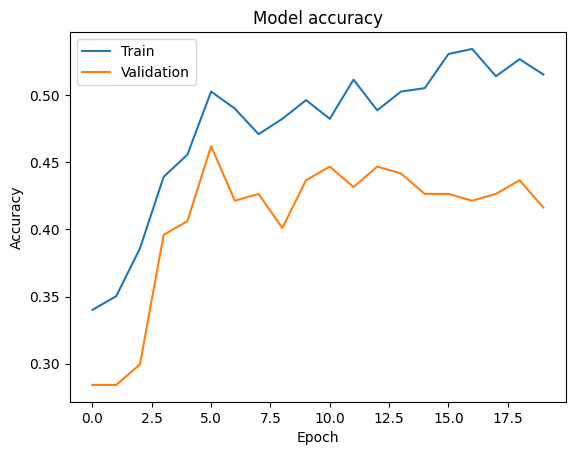

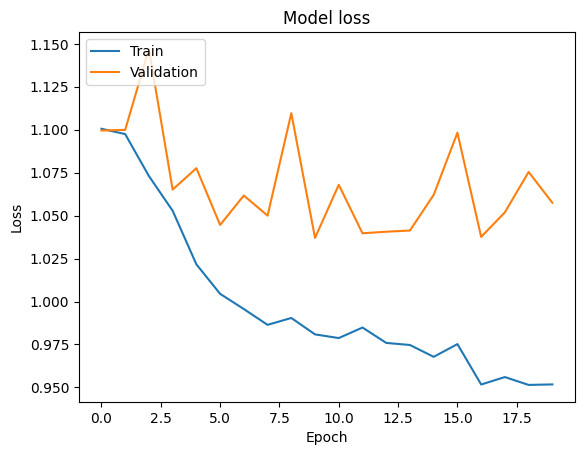

In [8]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Sample Prediction

In [9]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=img_dimensions
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
This image is 0.90 percent curly hair, 0.06 percent straight hair, and 0.03 percent wavy hair.
